In [ ]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.nuscenes import RadarPointCloud
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix

import operator
import time

import cv2
import numpy as np
import open3d as o3d
from mayavi import mlab
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from pyquaternion import Quaternion

In [ ]:
nusc = NuScenes(version='v1.0-mini', 
                dataroot='/home/charles/myDataSet/nuScenes/v1.0-mini', verbose=True)

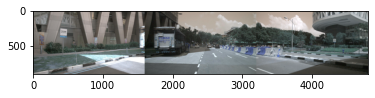

In [5]:
scene = nusc.scene[0] 

# 获取该场景的first token
cur_sample_info = nusc.get('sample', scene['first_sample_token'])

# print(path_)
img_pos_list = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
img_list = []
for cam_ in img_pos_list:
    img_path_ = nusc.get_sample_data_path(cur_sample_info['data'][cam_])
    img = cv2.imread(img_path_)
    img_list.append(img)

img_all1 = np.hstack((np.hstack((img_list[0], img_list[1])), img_list[2]))
plt.imshow(img_all1)